## Task:  
Telecom churn prediction.  
Metric - F1-score.  
Model - LogReg (baseline) and XGBoost.

In [1]:
import itertools
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from IPython.display import display
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.exceptions import ConvergenceWarning, DataConversionWarning

%matplotlib inline

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=DataConversionWarning)
pd.options.display.max_columns=100
pd.options.display.max_rows=100
sns.set_style('whitegrid', rc={'grid.linestyle': '--'});

### Load data

In [2]:
# Function to display key information about dataset
def preview_data(data):
    print("data shape: {}".format(data.shape))
    print("size, MB: {:.1f}".format(data.memory_usage(deep=True).sum() / 1e6))
    display(pd.concat([data.isnull().sum().rename("NaN"), 
                       data.nunique().rename("n_unique"),
                       data.dtypes.rename("dtype")], axis=1))
    display(data.head(1))


# General data
general = pd.read_csv("IBM/general_final.csv", parse_dates=["date_reg"])
preview_data(general)

data shape: (240000, 12)
size, MB: 158.0


,NaN,n_unique,dtype
client_id,0,240000,object
date_reg,0,61,datetime64[ns]
market,0,84,object
group,0,46,object
archetype,0,17,object
hardware,0,2,object
channel,0,35,object
dealer,0,24,object
phone,14835,3352,object
type_t,14835,13,object


,client_id,date_reg,market,group,archetype,hardware,channel,dealer,phone,type_t,device,churn
0,09777552-cc75-4f03-9438-11c3a7480f97,2016-05-10,R25,PP1_9,PP2_0,PPT1,C1_22,C2_22,D2254,DT1_6,DT2_5,0.0


In [3]:
# Traffic data
traf = pd.read_csv("IBM/traf_final.csv", dtype={"day": int, "client_id": "category"})
preview_data(traf)

data shape: (3726461, 8)
size, MB: 241.5


,NaN,n_unique,dtype
client_id,0,240000,category
day,0,30,int32
call_in_num,0,182,float64
call_out_num,0,408,float64
call_in_dur,0,13336,float64
call_out_dur,0,16171,float64
sms_out_num,0,758,float64
gprs,0,557206,float64


,client_id,day,call_in_num,call_out_num,call_in_dur,call_out_dur,sms_out_num,gprs
0,09777552-cc75-4f03-9438-11c3a7480f97,7,0.0,3.0,0.0,418.0,0.0,0.0


In [4]:
# Recharge data
rech = pd.read_csv("IBM/rech_final.csv", dtype={"day": int, "client_id": "category"})
preview_data(rech)

data shape: (467676, 3)
size, MB: 27.0


,NaN,n_unique,dtype
client_id,0,153321,category
day,0,30,int32
recharges,0,13106,float64


,client_id,day,recharges
0,6cac2aeb-1816-498f-ad36-c1f27ee3044a,17,333.704


In [5]:
# Balance data
balance = pd.read_csv("IBM/balance_final.csv", dtype={"day": int, "client_id": "category"})
preview_data(balance)

data shape: (7200000, 3)
size, MB: 148.0


,NaN,n_unique,dtype
client_id,0,240000,category
day,0,30,int32
balance,0,269984,float64


,client_id,day,balance
0,c602c1cf-71d4-413e-a8fe-c9c76abbb14f,0,3225.805111


### Data exploration

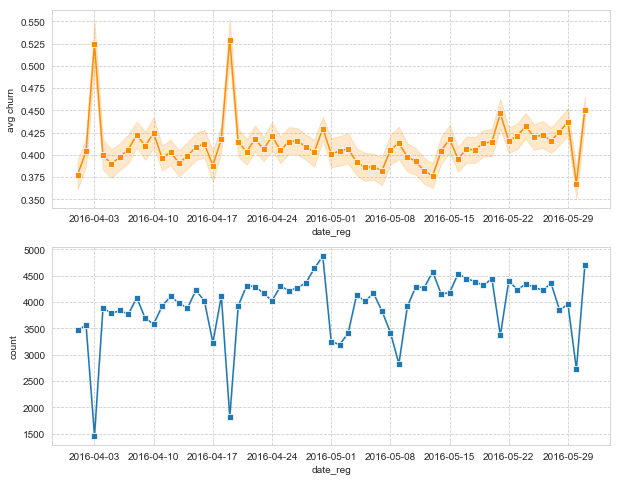

In [6]:
# Churn rate and count
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 8));

sns.lineplot(x="date_reg", y="churn", data=general, marker="s",
             color="darkorange", ax=ax[0]).set_ylabel("avg churn");

sns.lineplot(x="date_reg", y="churn", data=general, marker="s",
             estimator=len, ax=ax[1]).set_ylabel("count");

→ classes are slightly imbalanced  
→ there are at least 2 anomalous peaks in daily churn data - correspond to rapid drop in registrations

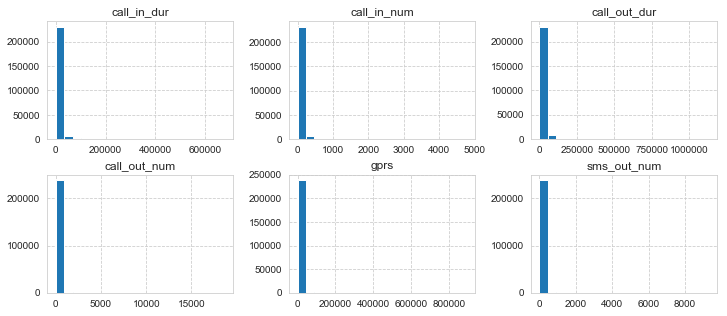

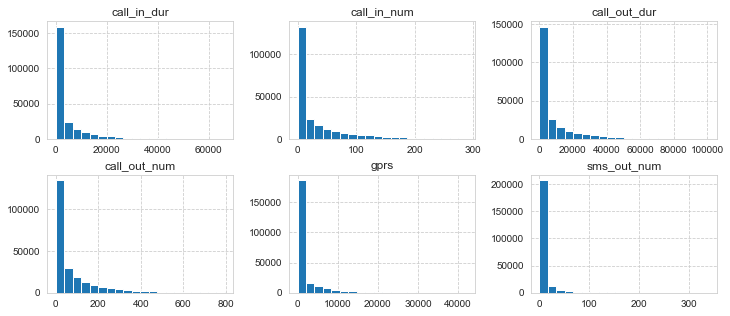

In [7]:
# Traffic data
traf.drop("day", axis=1).groupby("client_id").agg("sum") \
    .hist(layout=(2,3), figsize=(12,5), bins=20);

# Traffic data after dropping outliers
def mask_outliers(series, q=.01):
    series[(series < series.quantile(q)) | (series > series.quantile(1-q))] = np.nan
    return series

traf.drop("day", axis=1).groupby("client_id").agg("sum").apply(mask_outliers) \
    .hist(layout=(2,3), figsize=(12,5), bins=20);

→ there are users with huge traffic volume consumed  
→ traffic data distributions are highly skewed to the right  
→ many users have traffic volume around zero - might be informative feature

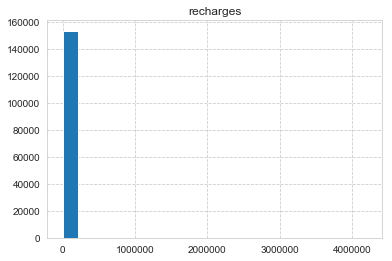

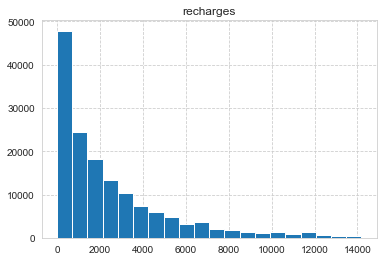

In [8]:
# Recharge data
rech.drop("day", axis=1).groupby("client_id").agg("sum").hist(bins=20)

# Recharge data after dropping outliers
rech.drop("day", axis=1).groupby("client_id").agg("sum").apply(mask_outliers) \
    .hist(bins=20);

→ recharge distribution is very similar to traffic data  
→ substantial share of users do not have recharge data - might be extremely useful feature

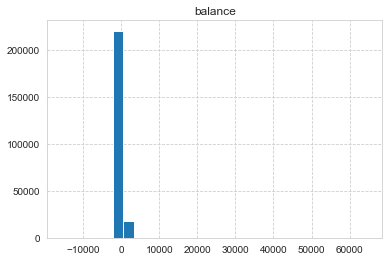

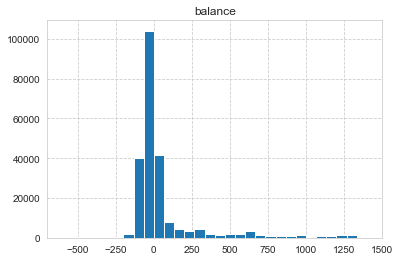

In [9]:
# Balance data
balance.drop("day", axis=1).groupby("client_id").agg("min").hist(bins=30);

# Balance data after dropping outliers
balance.drop("day", axis=1).groupby("client_id").agg("min").apply(mask_outliers) \
        .hist(bins=30);

→ min balance can be zero or even negative - might help to find churning customers 

### Feature engineering

In [6]:
# Missing values in categorical features
general.fillna(value="missing", inplace=True)

# Phone has a lot of unique values - leave only most common
phone_top = (general.groupby("phone").size() > 1000).to_frame("n").query("n == True").index
general.loc[~general["phone"].isin(phone_top), "phone"] = "other"

# Categorical columns to dummy variables
cols_dummy = ["market", "group", "archetype", "hardware", "channel", 
              "dealer", "phone", "type_t", "device"]

general = pd.get_dummies(general, drop_first=True, columns=cols_dummy)
print(general.shape)

# There are "strange" days which have substantial drops in activation count
# Let's pretend we know that something bad happened on those days
general["strange_date"] = np.where(general["date_reg"].isin(["2016-04-03", "2016-04-19"]), 1, 0)

(240000, 251)


In [7]:
# There are missing rows in traffic data and recharge data
# i.e. ex. we have only days when any traffic consumption happened
# however we need all days as in balance dataframe
assert len(set(traf.client_id.unique()) & set(balance.client_id.unique())) == 240_000

# Merge balance and traffic and recharge dataframes
event = pd.merge(balance, traf, how="left", on=["client_id", "day"])
event = pd.merge(event, rech, how="left", on=["client_id", "day"])
event.fillna(0, inplace=True)

print(event.shape)
event.head(2)

(7200000, 10)


,client_id,day,balance,call_in_num,call_out_num,call_in_dur,call_out_dur,sms_out_num,gprs,recharges
0,c602c1cf-71d4-413e-a8fe-c9c76abbb14f,0,3225.805111,0.0,0.0,0.0,0.0,0.0,51.504642,0.0
1,c602c1cf-71d4-413e-a8fe-c9c76abbb14f,1,3114.570222,0.0,0.0,0.0,0.0,0.0,40.975853,0.0


In [10]:
agg_funcs = ["max", "min", "mean", "std", "sum"]

# Generate some global features
event_global = event.drop("day", axis=1).groupby("client_id").agg(agg_funcs)
event_global.columns = ["_".join(x) for x in event_global.columns.get_values()]

# Features for last 1 / 3 / 7 days
event_last1 = event[event["day"] == 29].drop("day", axis=1).set_index("client_id")

event_last3 = event[event["day"].isin(range(27,30))].drop("day", axis=1) \
                                .groupby("client_id").agg(agg_funcs)

event_last7 = event[event["day"].isin(range(23,30))].drop("day", axis=1) \
                                .groupby("client_id").agg(agg_funcs)

for df, i in zip([event_last3, event_last7], ["3", "7"]):
    df.columns = ["_".join(x) + "_" + i for x in df.columns.get_values()]

event_final = pd.concat([event_global, event_last1, event_last3, event_last7], 
                        axis=1, join="inner", sort=True, verify_integrity=True)

# Merge with general dataframe
data = pd.merge(general.set_index("client_id"), event_final, how="left", 
                left_index=True, right_index=True)

print(data.shape)
print(data.isnull().sum().sum())

(240000, 379)
0


In [11]:
# Pickle processed data
data.to_pickle("IBM/data.pcl")
data = pd.read_pickle("IBM/data.pcl")

In [33]:
# Train / test data
data_train = data[data["date_reg"] < "2016-05-13"].drop("date_reg", axis=1)
data_test = data[data["date_reg"] >= "2016-05-13"].drop("date_reg", axis=1)

# Features / target variables
X_train, y_train = data_train.drop("churn", axis=1), data_train["churn"]
X_test, y_test = data_test.drop("churn", axis=1), data_test["churn"]
print(X_train.shape, X_test.shape)

(160529, 377) (79471, 377)


### Baseline model

Let's fit logistic regression as baseline model

In [13]:
# CV generator
skf = StratifiedKFold(n_splits=5, random_state=13)

# Pipeline for correct work with StandardScaler
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('clf', LogisticRegression(solver="saga", class_weight="balanced", max_iter=500))])

# Params grid
params = {"clf__C": [1e-2, 1e-1, 1, 2]}

# Grid search
gs = GridSearchCV(pipe,
                  params, 
                  scoring="f1", 
                  cv=skf, 
                  verbose=1, 
                  n_jobs=6,
                  return_train_score=True);

gs.fit(X_train, y_train);
f1_test = f1_score(y_test, gs.predict(X_test))

print("F1 on test set: {:.2f}".format(f1_test))
print(gs.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed: 132.3min finished


F1 on test set: 0.71
{'clf__C': 0.01}


### XGBoost

In [39]:
# Function to tune XGBoost hyperparameters
def xgb_tune_params(dtrain, params, grid_tuned):    
    loss_min = float("Inf")
    best_params = None
    features = grid_tuned.keys()
    iters = itertools.product(*grid_tuned.values())
    for it in iters:
        i_grid = dict(zip(features, it))
        params.update(i_grid)
        print("CV with {}".format(i_grid))
        cv_results = xgb.cv(params,
                            dtrain, 
                            num_boost_round=1000,
                            seed=13, 
                            folds=skf,
                            metrics={"logloss"},                            
                            early_stopping_rounds=50)
        loss_cv = cv_results["test-logloss-mean"].min()
        boost_rounds = cv_results["test-logloss-mean"].idxmin()
        print("\tlogloss {:.4f} for {} rounds".format(loss_cv, boost_rounds))
        if loss_cv < loss_min:
            loss_min = loss_cv
            best_params = i_grid
    params.update(best_params)
    print("Best params: {}, logloss: {}".format(best_params, loss_min))
    return params

In [35]:
# Split into train / validation set for early stopping
X_train, X_val, y_train, y_val = train_test_split(X_test, y_test, test_size=0.15, random_state=13)

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

In [46]:
# Initialize parameters
params = {'eval_metric': 'logloss',
          'tree_method': 'hist',
          'objective': 'binary:logistic',
          'silent': True,
          'scale_pos_weight': sum(y_train==0) / sum(y_train==1), # unbalanced classes
          'eta': 0.1,
          'max_depth': 7,
          'min_child_weight': 3,
          'nthread': 7,
          'subsample': 0.8,
          'colsample_bytree': 0.6,
          'lambda': 10,
          'alpha': 0,
          'gamma': 0.3,
        }

Tune tree-specific parameters

In [ ]:
%%capture
params_tune = {"max_depth": [3, 5, 7],
               "min_child_weight": [1, 3, 5]
              }

params = xgb_tune_params(dtrain, params, params_tune)

Tune $\gamma$ regularization parameter

In [ ]:
%%capture
params_tune = {"gamma": [0, .1, .2, .3, .4, .5, .6]
              }

params = xgb_tune_params(dtrain, params, params_tune)

Downsampling observations and feature space 

In [ ]:
%%capture
params_tune = {"subsample": [.6, .7, .8, .9],
               "colsample_bytree": [.6, .7, .8, .9],
              }

params = xgb_tune_params(dtrain, params, params_tune)

Tune $\alpha$ and $\lambda$ parameters ($L1$ / $L2$ regularization)

In [ ]:
%%capture
params_tune = {"lambda": [0, 10, 100],
               "alpha": [0, 1e-3, 1e-2]
              }

params = xgb_tune_params(dtrain, params, params_tune)

Increase number of boosted trees and train using tuned parameters

In [55]:
model = xgb.train(params, 
                  dtrain, 
                  num_boost_round=5000,
                  evals=[(dval, "validation")],
                  early_stopping_rounds=50, 
                  verbose_eval=200)

f1_test = f1_score(y_test, model.predict(dtest) > 0.5)
print("F1 on test set: {:.2f}".format(f1_test))

[20:05:31] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[0]	validation-logloss:0.65925
Will train until validation-logloss hasn't improved in 50 rounds.
[200]	validation-logloss:0.464452
Stopping. Best iteration:
[268]	validation-logloss:0.463909

F1 on test set: 0.81


**Results (F1-measure):**
- Logistic regression (baseline): 0.71
- XGBoost: 0.81

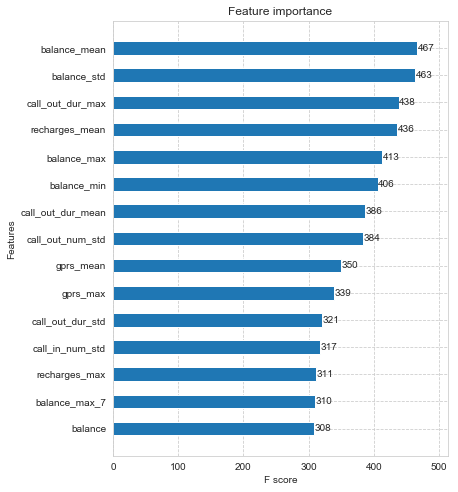

In [56]:
# Most important features
# might be helpful for subsequent feature engineering process
fig, ax = plt.subplots(figsize=(6,8));
xgb.plot_importance(model, max_num_features=15, height=.5, ax=ax);